# Import thư viện cần thiết

In [ ]:
#Mục đích thống kê data
import pandas as pd
import matplotlib.pyplot as plt

#Chia data
from sklearn.model_selection import train_test_split

import time

#Clean data
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import tokenize

#Vẽ biểu đồ 
import numpy as np
import seaborn as sb

#Chuyển data thành dạng ma trận số
from sklearn.feature_extraction.text import CountVectorizer

#Tạo và chạy model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [ ]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection"

/content/drive/MyDrive/Colab Notebooks/Fake_News_Detection


# Thống kê dữ liệu

In [ ]:
#Fake news 
fake = pd.read_json('data_fake_news.json')
fake

,date,title,text,is_fake
0,2021-05-28 00:00:00,US Mint Delays Silver Shipments Due To “Global...,Interest in silver is soaring (both for indust...,1
1,2021-06-28 00:00:00,"Research Paper Exposes Cybersecurity, Environm...",A 2018 survey revealed did NOT want to live i...,1
2,2021-05-29 00:00:00,DeSantis’s Anti-Riot Law Undermines Two Import...,When Florida Gov. Ron DeSantis spent the last ...,1
3,2021-05-28 00:00:00,Another Massive Cargo Ship Was Just Stuck In t...,To quote the great Los Angeles sportscaster Vi...,1
4,2021-06-25 00:00:00,BofA Crashes The “Transitory” Party: Sees Up T...,"At the start of May, when observing the avalan...",1
...,...,...,...,...
231613,2021-05-25,Lisa Murkowski Comes Out In Favor Of Investiga...,she is supporting a bill to create an indepen...,1
231614,2021-05-23,Biden Cancels Trump And Reinstates LGBTQ Prote...,Maddow said this about book on‘[Del Perccio sh...,1
231615,2021-05-25,Company Helping Run AZ Election Audit Abandons...,The contract that looped the company into the...,1
231616,2021-05-20,Biden VS Trump Polling Matchup Has GOP Clutchi...,2024 National GE:Biden 48% (+12)Trump 36%,1


In [ ]:
#Real news
real = pd.read_json('data_real_news.json')
real

,date,title,text,is_fake
0,2021-06-24 00:00:00,We’re hiring: a news assistant in Tokyo,"is seeking a . This is an exciting, multiface...",0
1,2021-06-24 00:00:00,An important census product may soon use synth...,"(), which is sent to around 1% of America’s p...",0
2,2021-06-24 00:00:00,Myanmar’s civil war is becoming bloodier and m...,"bicycle, wearing a -shirt emblazoned with a c...",0
3,2021-06-24 00:00:00,America’s Supreme Court is less one-sided than...,America’s Supreme Court seemed destined for a...,0
4,2021-06-12 00:00:00,The anti-graft unit of China’s Communist Party...,"June 1st Shi Zhaoqing, a local boss in China’...",0
...,...,...,...,...
253933,2018-01-01 00:00:00,Detectives: Florida man beat 6-year-old stepso...,"Jack Junior Montgomery, 31, has been charged w...",0
253934,2018-01-01 00:00:00,1 dead after shooting at New Year’s Eve party ...,Officers responded to the home near Northwest ...,0
253935,2018-01-01 00:00:00,Prosecutor: Teen held in shooting death of par...,Monmouth County Prosecutor Chris Gramiccioni s...,0
253936,2018-01-01 00:00:00,Man hospitalized due to firework injury in NW ...,"The victim, identified as 25-year-old Orlando ...",0


In [ ]:
print("Fake news size: ", len(fake), "\nReal news size: ", len(real))

Fake news size:  231618 
Real news size:  253938


In [ ]:
dataset = real.append(fake).sample(frac=1).reset_index(drop=True)
dataset

,date,title,text,is_fake
0,"May 23, 2019",What Bias? Facebook Suspends Conservative Rahe...,With each new day Facebook becomes open with t...,1
1,2019-05-15 00:00:00,"Timing Is Everything, The Economic Plan Behind...",Trump explains why the trade deal is not that ...,1
2,2021-04-13 00:00:00,The Coronavirus Vaccine Passport Is Here,The small Caribbean island of St. Vincent has ...,1
3,2020-03-20 00:00:00,Publix to hire ‘thousands’ of associates to ke...,"Angel Coelho, a Publix shopper said, “A lot of...",0
4,"March 19, 2020","In Turkey, Coronavirus Spurs A Surge In Cologn...",The coronavirus pandemic has shuttered shops a...,0
...,...,...,...,...
485551,2018-04-16 00:00:00,Breaking: Syrian air defense fires missiles at...,"BEIRUT, LEBANON (12:45 A.M.) – Minutes ago, un...",1
485552,2020-12-21 14:41:00,This hidden Amazon deal gets you 2020’s hottes...,and to and all the,0
485553,2019-05-16 00:00:00,Rahul Gandhi’s former partner in British compa...,Rahul Gandhi’s has become a raging issue this...,1
485554,2018-06-05 14:54:00,How iOS 12 could make iPhones way more difficu...,"With the release of the first beta of iOS 12, ...",0


# Thống kê theo số lượng thật giả

([<matplotlib.patches.Wedge at 0x7f4a5215c410>,
 [Text(1.0971336860234244, 0.07935789181079546, 'Fake'),
  Text(-1.0971336860234244, -0.0793578918107955, 'Real')],
 [Text(0.5984365560127769, 0.04328612280588843, '47.7%'),
  Text(-0.5984365560127769, -0.04328612280588845, '52.3%')])

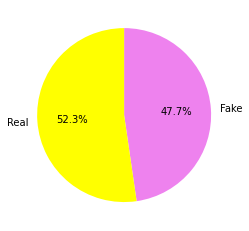

In [ ]:
size = [len(fake['is_fake']), len(real['is_fake'])]
colors = ['violet', 'yellow']
plt.pie(size, labels=['Fake', 'Real'], colors=colors, autopct='%1.1f%%', startangle=90,counterclock=False)

# Thống kê theo số lượng từ trong text

In [ ]:
len_sentence = dataset['text']
seq_len = [len(i.split()) for i in len_sentence]
#Hàm đếm số lượng từ và phân loại
len_sen = {}
for item in seq_len:
  if item not in len_sen.keys():
    len_sen[item] = 1
  else:
    len_sen[item] += 1

Text(0.5, 1.0, 'Numbers of words in text')

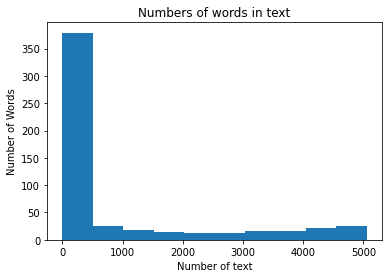

In [ ]:
plt.hist(len_sen.values())
plt.ylabel('Number of Words')
plt.xlabel('Number of text')
plt.title('Numbers of words in text')

# Theo năm bài báo được đăng

In [ ]:
#Hàm đếm số lượng mỗi bài báo trong những năm được cho phép <=> 3 năm trở lại <=> 2021, 2020, 2019, 2018
dictionary = {
    '2021': 0,
    '2020': 0,
    '2019': 0,
    '2018': 0
}
for row in range(len(dataset)):
  for key in dictionary.keys():
    if key in dataset.iloc[row]['date']:
      dictionary[key] += 1

([<matplotlib.patches.Wedge at 0x7f4a520c9810>,
 [Text(0.6047465786071093, 0.9188479611246877, '2021'),
  Text(0.9149041635938293, -0.6106966279902613, '2020'),
  Text(-0.8226741720113389, -0.7302103852352815, '2019'),
  Text(-0.73553371972063, 0.817918178764804, '2018')],
 [Text(0.3298617701493323, 0.5011897969771023, '18.5%'),
  Text(0.4990386346875432, -0.3331072516310516, '31.7%'),
  Text(-0.4487313665516393, -0.39829657376469896, '26.5%'),
  Text(-0.4012002107567072, 0.4461371884171658, '23.3%')])

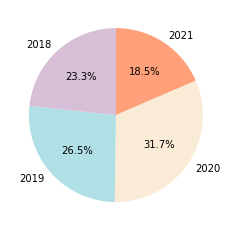

In [ ]:
size = dictionary.values()
colors = ['lightsalmon', 'antiquewhite', 'powderblue', 'thistle']
plt.pie(size, labels=['2021', '2020', '2019', '2018'], colors=colors, autopct='%1.1f%%', startangle=90, counterclock=False)

# Split data (Nam)


In [ ]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print("Train size: ", len(train))
train.head()

Train size:  388444


,date,title,text,is_fake
0,2018-05-06 00:00:00,Sheriff: Highway sniper “idolized” Parkland sc...,A sheriff says 26-year-old landscaper Rex Whit...,0
1,2018-09-30 00:00:00,"This driver saw an accident, and he did what m...","December, I didn’t expect that my interaction...",1
2,"April 11, 2021 11:40 AM","Sixth Victim of South Carolina Shooting, Who I...",", who was the sole survivor of a mass shooting...",0
3,2018-06-01,W.H. Goes Silent; Federal Judge Rules In Favor...,Manafort was the chairman of the Trump campaig...,1
4,2019,Be Healthy and Youthful: Put An Ice Cube At Th...,There is a point at the base of the neck known...,1


In [ ]:
print("Test size: ", len(test))
test.head()

Test size:  97112


,date,title,text,is_fake
0,"October 29, 2020",COVID-19 Has Robbed The World's Poorest Childr...,An employee adjusts desks in an empty classroo...,0
1,2019-05-16T17:50:23+00:00,Samantha Bee Schools Anti-Abortion Legislators...,"This week, Alabama passed a law that will proh...",0
2,2019-07-10 15:34:00,Astronomers just spotted two supermassive blac...,"nothing. In a new paper published in the , re...",0
3,2018-09-28 13:54:00,This pillow’s smart design makes it perfect fo...,is the answer. How did the company manage to ...,0
4,2018-11-12 00:00:00,ANOTHER Fox Personality Harassed by the ‘Toler...,"Awww, the tolerant Left strikes again …I was j...",1


# Clean Data (Nam)

In [ ]:
#Loại bỏ những cột không cần dùng đến
train = train.drop(["date"],axis=1)
train = train.drop(["title"],axis=1)
train

,text,is_fake
0,A sheriff says 26-year-old landscaper Rex Whit...,0
1,"December, I didn’t expect that my interaction...",1
2,", who was the sole survivor of a mass shooting...",0
3,Manafort was the chairman of the Trump campaig...,1
4,There is a point at the base of the neck known...,1
...,...,...
388439,Klain will lead a White House likely to be con...,0
388440,"by , a flock of starlings — also known by the...",0
388441,"Presidential son Donald Trump, Jr. called out ...",1
388442,") Hearing loss by up to 17 percent, according...",1


In [ ]:
#make the text lowercase (case Sensitivity)
train['text'] = train['text'].apply(lambda x: x.lower())
train.head()

,text,is_fake
0,a sheriff says 26-year-old landscaper rex whit...,0
1,"december, i didn’t expect that my interaction...",1
2,", who was the sole survivor of a mass shooting...",0
3,manafort was the chairman of the trump campaig...,1
4,there is a point at the base of the neck known...,1


In [ ]:
# Remove punctuation
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

In [ ]:
train['text'] = train['text'].apply(punctuation_removal)
train.head()

,text,is_fake
0,a sheriff says 26yearold landscaper rex whitmi...,0
1,december i didn’t expect that my interaction ...,1
2,who was the sole survivor of a mass shooting ...,0
3,manafort was the chairman of the trump campaig...,1
4,there is a point at the base of the neck known...,1


In [ ]:
#Stemming is a process of reducing a word to its root stem
import re
stemming = PorterStemmer()

def Stemming(text):

  #splitting tokens (split whitespace, non-word like "text-based" to "text" "based")
  words = re.split(r"\W", text)
  

  for word in words:
    word = stemming.stem(word)
  clean_str = ' '.join(words)
  return clean_str

In [ ]:
train['text'] = train['text'].apply(Stemming)
train.head()

,text,is_fake
0,a sheriff says 26yearold landscaper rex whitmi...,0
1,december i didn t expect that my interaction ...,1
2,who was the sole survivor of a mass shooting ...,0
3,manafort was the chairman of the trump campaig...,1
4,there is a point at the base of the neck known...,1


In [ ]:
#delete stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train.head()

,text,is_fake
0,sheriff says 26yearold landscaper rex whitmire...,0
1,december expect interaction cab driver leave e...,1
2,sole survivor mass shooting south carolina wed...,0
3,manafort chairman trump campaign one time sitt...,1
4,point base neck known feng fu feng fu pressure...,1


# Những từ thường xuất hiện

In [ ]:
sw = set(STOPWORDS)
sw.update(["drink", "now", "wine", "flavor", "flavors"])

In [ ]:
real = train.loc[(train.is_fake == 0)]

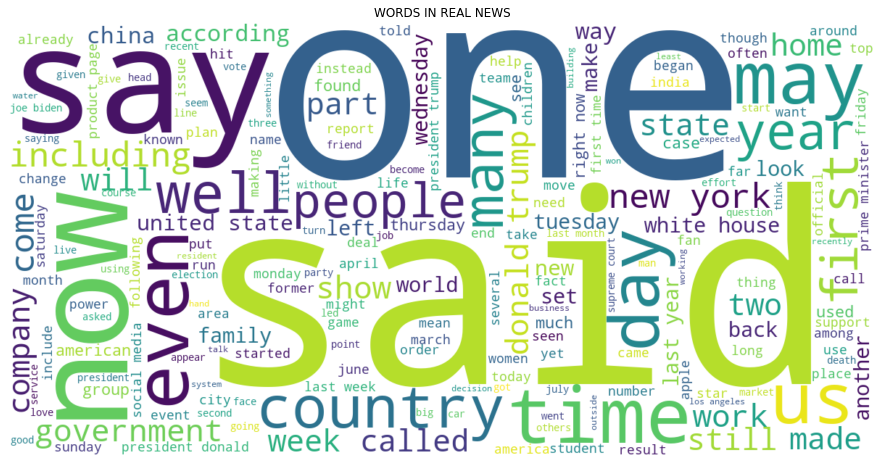

In [ ]:
wordcloud = WordCloud(width = 1200, height = 600, background_color="white").generate(' '.join(real.text))
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WORDS IN REAL NEWS")
plt.axis("off")
plt.show()

In [ ]:
fake = train.loc[(train.is_fake == 1)]

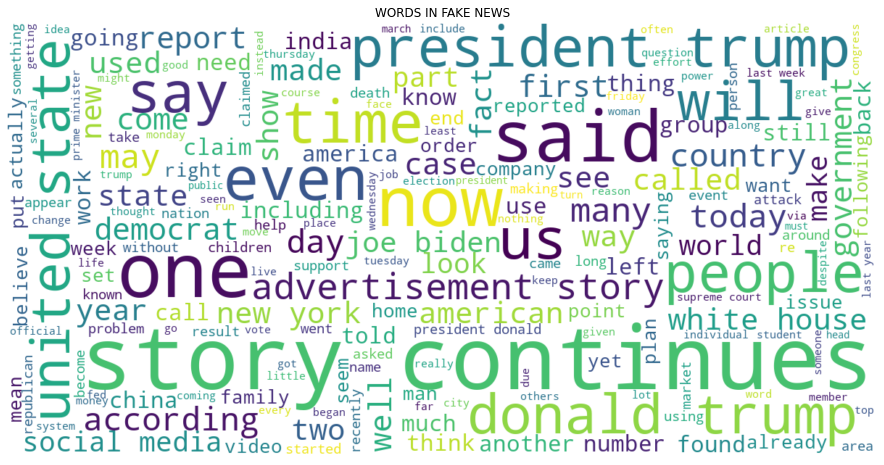

In [ ]:
wordcloud = WordCloud(width = 1200, height = 600, background_color="white").generate(' '.join(fake.text))
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WORDS IN FAKE NEWS")
plt.axis("off")
plt.show()

In [ ]:
token_space = tokenize.WhitespaceTokenizer()
all_words = ' '.join([text for text in real.text])
token_phrase = token_space.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"word": list(frequency.keys()),
                             "frequency": list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "frequency", n = 20)

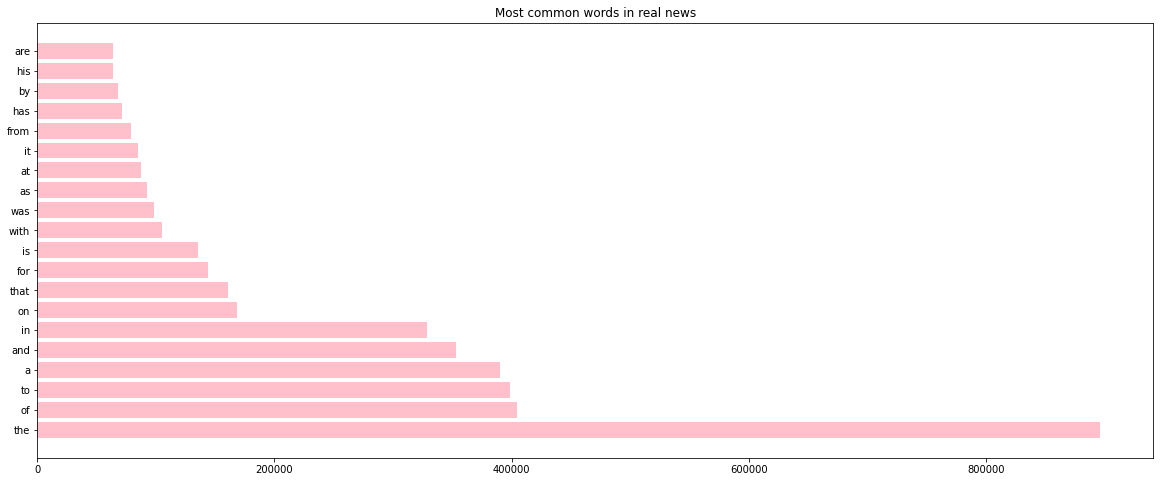

In [ ]:
x_pos = [i for i, _ in enumerate(df_frequency.word)]
plt.figure(figsize=(20,8))
plt.barh(x_pos, df_frequency.frequency, color='pink')
plt.title("Most common words in real news")
plt.yticks(x_pos, df_frequency.word)
plt.show()

In [ ]:
all_words = ' '.join([text for text in fake.text])
token_phrase = token_space.tokenize(all_words)
frequency = nltk.FreqDist(token_phrase)
df_frequency = pd.DataFrame({"word": list(frequency.keys()),
                             "frequency": list(frequency.values())})
df_frequency = df_frequency.nlargest(columns = "frequency", n = 20)

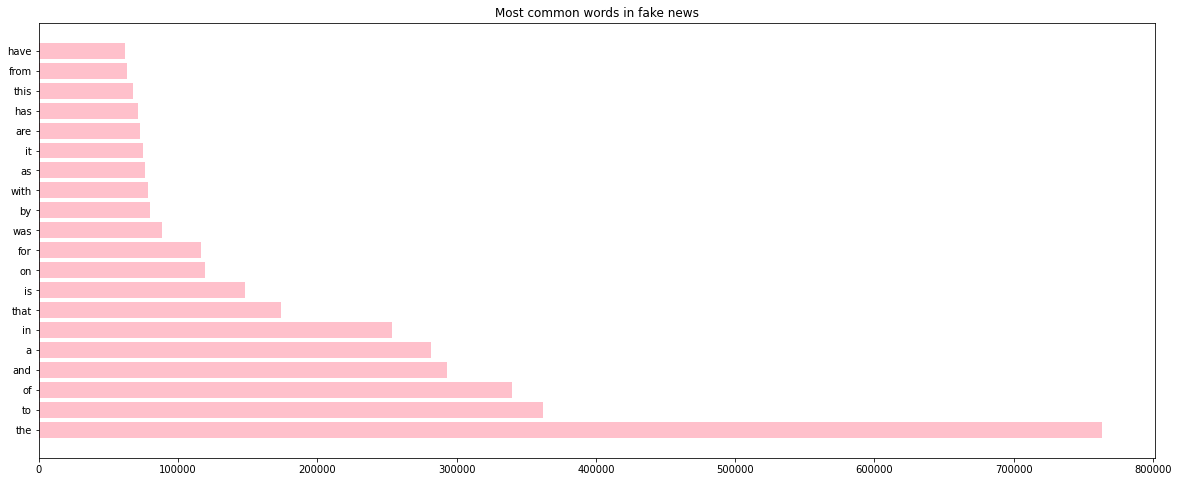

In [ ]:
x_pos = [i for i, _ in enumerate(df_frequency.word)]
plt.figure(figsize=(20,8))
plt.barh(x_pos, df_frequency.frequency, color='pink')
plt.title("Most common words in fake news")
plt.yticks(x_pos, df_frequency.word)
plt.show()

In [ ]:
#Loại bỏ những cột không cần thiết trong test
test = test.drop(["date"],axis=1)
test = test.drop(["title"],axis=1)
test

,text,is_fake
0,An employee adjusts desks in an empty classroo...,0
1,"This week, Alabama passed a law that will proh...",0
2,"nothing. In a new paper published in the , re...",0
3,is the answer. How did the company manage to ...,0
4,"Awww, the tolerant Left strikes again …I was j...",1
...,...,...
97107,‘s attacking 16-year-old Swedish activist aft...,0
97108,5G is being installed all over the U.S. despit...,1
97109,The US policies in the Middle East have increa...,1
97110,The deepening worries over newly protectionist...,0


In [ ]:
#Quan sát lại bộ dữ liệu 1 lần nữa
def data_obs():
    print("Training dataset size:")
    print(train.shape)
    print(train.head(10))

    print("Testing dataset size:")
    print(test.shape)
    print(test.head(10))

In [ ]:
data_obs()

Training dataset size:
(388444, 2)
                                                text  is_fake
0  sheriff says 26yearold landscaper rex whitmire...        0
1  december expect interaction cab driver leave e...        1
2  sole survivor mass shooting south carolina wed...        0
3  manafort chairman trump campaign one time sitt...        1
4  point base neck known feng fu feng fu pressure...        1
5  reports pilot flying boeing plane operated del...        0
6  evelio medina founder lawabiding citizens coal...        0
7  mark000people think fomc cut meeting 4 weeks i...        1
8  made appearance trooping colour alongside husband        0
9  many skeletons new jersey congressman exlobbyi...        1
Testing dataset size:
(97112, 2)
                                                text  is_fake
0  An employee adjusts desks in an empty classroo...        0
1  This week, Alabama passed a law that will proh...        0
2   nothing. In a new paper published in the , re...        0
3 

[Text(0.5, 1.0, 'Distribution in train')]

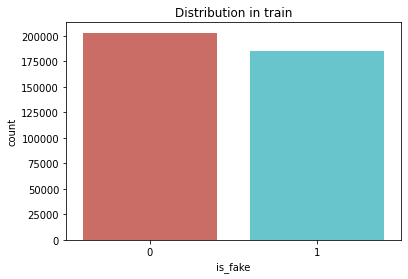

In [ ]:
#Create classes distribution 
sb.countplot(x='is_fake', data=train, palette='hls').set(title = "Distribution in train")

[Text(0.5, 1.0, 'Distribution in test')]

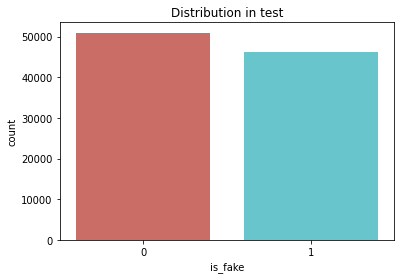

In [ ]:
sb.countplot(x='is_fake', data=test, palette='hls').set(title = "Distribution in test")

In [ ]:
#Kiểm tra xem có giá trị null hay không
def data_qualityCheck():
    
    print("Checking data qualitites...")
    train.isnull().sum()
    train.info()

    test.isnull().sum()
    test.info() 

    print("check finished.")

In [ ]:
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388444 entries, 0 to 388443
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     388444 non-null  object
 1   is_fake  388444 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97112 entries, 0 to 97111
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     97112 non-null  object
 1   is_fake  97112 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
check finished.


# Chuyển data thành dạng số - Dùng CountVectorize (Bag of words)

In [ ]:
#Chuyển đổi dữ liệu train
vectorizer = CountVectorizer()
train_data = vectorizer.fit_transform(train['text'])

In [ ]:
train_data.shape

(388444, 471600)

In [ ]:
#Chuyển đối dữ liệu test
test_data = vectorizer.transform(test['text'])

# Dùng logistic regression

In [ ]:
startTrain = time.time()
logR_clf = LogisticRegression(max_iter = 10000)
logR_clf.fit(train_data, train['is_fake'])
endTrain = time.time()
print("Training Time = ", endTrain - startTrain, "seconds")

Training Time =  677.341216802597 seconds


In [ ]:
startTest = time.time()
predicted_LogR = logR_clf.predict(test_data)
endTest = time.time()
print("Testing Time = ", endTest - startTest, "seconds")

Testing Time =  0.03235054016113281 seconds


In [ ]:
score = accuracy_score(test['is_fake'], predicted_LogR)
print("Accuracy score ~", round(score * 100, 2))
print(classification_report(test['is_fake'], predicted_LogR))

Accuracy score ~ 85.94
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     50771
           1       0.85      0.86      0.85     46341

    accuracy                           0.86     97112
   macro avg       0.86      0.86      0.86     97112
weighted avg       0.86      0.86      0.86     97112



Text(33.0, 0.5, 'True')

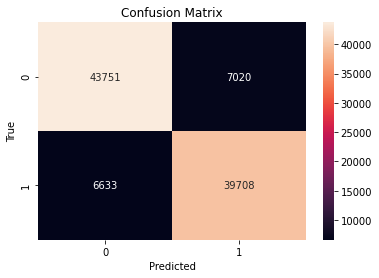

In [ ]:
matrix = confusion_matrix(test['is_fake'], predicted_LogR)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Dùng SVM 

In [ ]:
startTrain = time.time()
svm_clf = svm.LinearSVC(max_iter=10000)
svm_clf.fit(train_data, train['is_fake'])
endTrain = time.time()
print("Training Time = ", endTrain - startTrain, "seconds")

Training Time =  1173.0235040187836 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
startTest = time.time()
predicted_svm = svm_clf.predict(test_data)
endTest = time.time()
print("Testing Time = ", endTest - startTest, "seconds")

Testing Time =  0.032816171646118164 seconds


In [ ]:
score = accuracy_score(test['is_fake'], predicted_svm)
print("Accuracy score ~", round(score * 100, 2))
print(classification_report(test['is_fake'], predicted_svm))

Accuracy score ~ 84.38
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     50771
           1       0.84      0.83      0.84     46341

    accuracy                           0.84     97112
   macro avg       0.84      0.84      0.84     97112
weighted avg       0.84      0.84      0.84     97112



Text(33.0, 0.5, 'True')

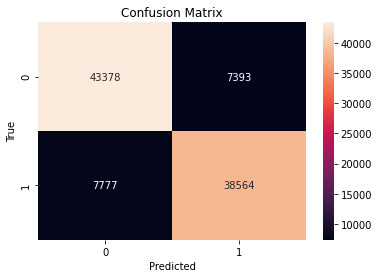

In [ ]:
matrix = confusion_matrix(test['is_fake'], predicted_svm)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Clean dataset và input để cải thiện accuracy

In [ ]:
def Clean_Data(string):
  string = string.lower()
  string = punctuation_removal(string)
  string = Stemming(string)
  return string

In [ ]:
#Chuyển về chữ thường, loại bỏ stop words,... trong test
test['text'] = test['text'].apply(lambda x: x.lower())
test['text'] = test['text'].apply(punctuation_removal)  
test['text'] = test['text'].apply(Stemming)
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

NameError: ignored

In [ ]:
test_data_clear = vectorizer.transform(test['text'])

# Logistic regression

In [ ]:
startTest = time.time()
predicted_LogR_clear = logR_clf.predict(test_data_clear)
endTest = time.time()
print("Testing Time = ", endTest - startTest, "seconds")
score = accuracy_score(test['is_fake'], predicted_LogR_clear)
print("Accuracy score ~", round(score * 100, 2))
print(classification_report(test['is_fake'], predicted_LogR_clear))
matrix = confusion_matrix(test['is_fake'], predicted_LogR_clear)
sb.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

NameError: ignored